In [1]:
import argparse
import pickle

import deepsnap as ds
import networkx as nx
import numpy as np
import math
from collections import defaultdict

from torch.utils.data import DataLoader

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
import torch_geometric as pyg

from tqdm import tqdm
import multiprocessing as mp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size': 16})

import sys
sys.path.append("/home/futy18/repos/Local/GNN/2021Summer")
from common import data, utils
from subgraph_counting.data import true_count_anchor, count_canonical_mp
sys.path.append("/home/futy18/repos/Local/GNN/2021Summer/playground/lib")
from Anchor import GetAnchoredGraph, GenVMap, SymmetricFactor
from common import data
from common import models
from common import utils

from subgraph_counting.config import parse_count
from subgraph_counting.data import count_canonical_mp, true_count_anchor, sample_neigh_canonical, count_canonical, get_neigh_canonical
from subgraph_counting.models import CanonicalCountModel
from subgraph_matching.config import parse_encoder

In [2]:
name = "ENZYMES"
dataset = TUDataset(root='../data/'+name, name=name)
query = nx.Graph(directed= False)

In [3]:
queries = []
atlas_graph = defaultdict(list)
for i in range(4, 1253):
    g = nx.graph_atlas(i) # range(0,1253)
    if sum(1 for _ in nx.connected_components(g)) == 1:
        atlas_graph[len(g)].append(g)
queries = atlas_graph[3] + atlas_graph[4] + atlas_graph[5] + atlas_graph[6] # + atlas_graph[7]

In [3]:
model = torch.load("/home/futy18/repos/Local/GNN/2021Summer/ckpt/tconv_sage_trans_345_syn_epo900.pt", map_location='cpu')
model.eval()

MultiTaskModel(
  (emb_model): BaselineGNN(
    (pre_mp): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
    )
    (convs): ModuleList(
      (0): TConv(64, 64)
      (1): TConv(128, 64)
      (2): TConv(192, 64)
      (3): TConv(256, 64)
      (4): TConv(320, 64)
      (5): TConv(384, 64)
      (6): TConv(448, 64)
      (7): TConv(512, 64)
    )
    (post_mp): Sequential(
      (0): Linear(in_features=576, out_features=64, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
      (5): Linear(in_features=64, out_features=256, bias=True)
      (6): ReLU()
      (7): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (emb_model_query): BaselineGNN(
    (pre_mp): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
    )
    (convs): ModuleList(
      (0): TConv(64, 64)
      (1): TConv(128, 64)
      (2): TConv

add to visualize params on 2021.12.9

In [17]:
layer = 2
params = dict()
for name, param in model.emb_model.convs[layer].named_parameters():
    print(name, param.shape)
    params[name] = param

lin_sps.weight torch.Size([64, 192])
lin_sps.bias torch.Size([64])
lin_dns.weight torch.Size([64, 192])
lin_dns.bias torch.Size([64])
lin_update.weight torch.Size([64, 256])
lin_update.bias torch.Size([64])


Text(0.5, 1.0, 'layer 2: diff')

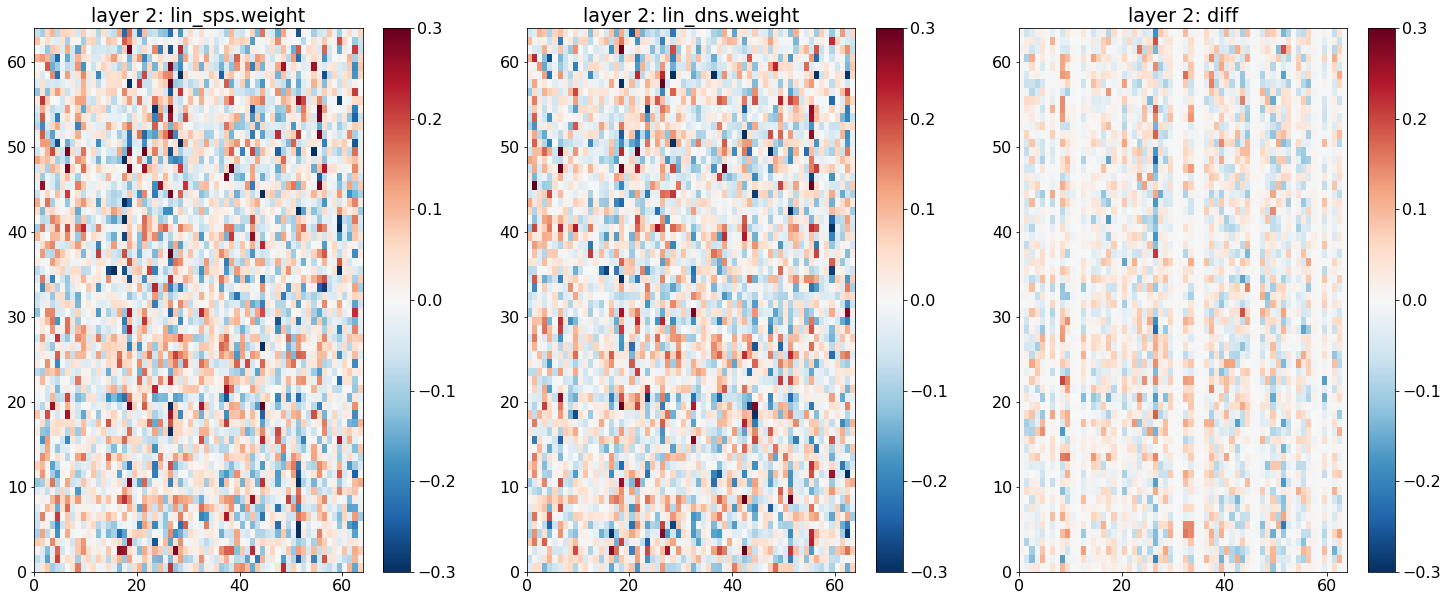

In [18]:
param1 = 'lin_sps.weight'
param2 = 'lin_dns.weight'

pic1 = params[param1].cpu().detach().numpy()[:,-64:]
pic2 = params[param2].cpu().detach().numpy()[:,-64:]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
ax = axes.flatten()

vmin = -0.3
vmax = 0.3
pcm = ax[0].pcolormesh(pic1, cmap= 'RdBu_r', norm= plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(pcm, ax=ax[0])
ax[0].set_title("layer "+str(layer)+': ' + param1)
pcm = ax[1].pcolormesh(pic2, cmap= 'RdBu_r', norm= plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(pcm, ax=ax[1])
ax[1].set_title("layer "+str(layer)+': ' + param2)

diff = (pic1-pic2)
pcm = ax[2].pcolormesh(diff, cmap= 'RdBu_r', norm= plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(pcm, ax=ax[2])
ax[2].set_title("layer "+str(layer)+': ' + 'diff')

In [4]:
# len_neighbor = nx.diameter(query)
len_neighbor =  max(nx.diameter(query) for query in queries)

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

model.to(device)

print("sample validation set")
neighs_valid = []
val_size = 64*25
for b in tqdm(range(val_size)):
    neighs_valid.append(sample_neigh_canonical(dataset, len_neighbor))

batch_size = 64
print("generating ground truth for test")
if len(neighs_valid) % batch_size != 0:
    print("WARNING: number of graphs not multiple of batch size")
truth_motif_valid = []
with mp.Pool(processes=8, maxtasksperchild=100) as pool:
    for query in tqdm(queries):
        truth_valid = []
        symmetry_factor = SymmetricFactor(query)
        for b in range(len(neighs_valid) // batch_size):
            top = (b+1)*batch_size
            batch = neighs_valid[b*batch_size:top]
            arg_tuple = tuple((query, target, symmetry_factor) for target in batch)
            truth = pool.starmap(count_canonical, arg_tuple)
            truth_valid.append(truth)
        truth_valid = torch.cat([torch.tensor(truth, dtype=torch.float) for truth in truth_valid], dim=-1) 
        truth_valid = torch.unsqueeze(truth_valid, -1).to(device)
        truth_motif_valid.append(truth_valid)

neighs_valid = utils.batch_nx_graphs(neighs_valid)



  0%|          | 7/1600 [00:00<00:24, 64.90it/s]

sample validation set


100%|██████████| 1600/1600 [00:14<00:00, 109.19it/s]

generating ground truth for test



100%|██████████| 29/29 [02:56<00:00,  6.07s/it]


In [ ]:
'''
with torch.no_grad():
    embs = model.emb_model(neighs_valid)
    pred = model.count_model(embs)
    pred = torch.round((F.relu(pred)))
    loss = model.criterion(pred, truth_valid)
    # loss = F.hinge_embedding_loss(pred, truth_valid)
    print("loss",loss.item())
'''

count_type = "multitask"
use_log = True

preds = []
losses = []
with torch.no_grad():
    for query_id in range(len(queries)):
        query = utils.batch_nx_graphs([queries[query_id] for _ in range(val_size)])
        truth_valid = truth_motif_valid[query_id]

        emb_target = model.emb_model(neighs_valid)
        if count_type == "motif":
            emb_query = model.emb_model_query(query)
            emb = torch.cat((emb_target, emb_query), dim=-1)
            count = model.count_model(emb)
            if use_log:
                count = 2**count - 1
            results = torch.round((F.relu(count)))
        elif count_type == "multitask":
            emb_query = model.emb_model_query(query)
            emb = torch.cat((emb_target, emb_query), dim=-1)
            count = model.count_model(emb)
            if use_log:
                count = torch.round(F.relu(2**count - 1))
            pred_label = model.classification(emb)
            results = (count, pred_label)
        elif count_type == "canonical":
            count = model.count_model(emb_target)
            if use_log:
                count = 2**count - 1
            results = torch.round((F.relu(count)))
        
        if count_type == "multitask":
            pred = results[0]
        else:
            pred = results
        loss = model.criterion(results, truth_valid)
        preds.append(pred)
        losses.append(loss)

preds = torch.cat(preds, dim=-1)
losses = [loss.item() for loss in losses]
print(losses)

# print(pred.reshape([-1]))
# print(truth_valid.reshape([-1]))

preds_np = preds.cpu().numpy().T
truth_motif_np = torch.cat(truth_motif_valid, dim=-1).cpu().numpy().T

[573909.125, 1116132.5, 755020.375, 283494.96875, 101438.2265625, 63277.0703125]


## classification

In [10]:
if count_type == "multitask":
    pred_labels = []
    with torch.no_grad():
        for query_id in tqdm(range(len(queries))):
            query = utils.batch_nx_graphs([queries[query_id] for _ in range(val_size)])
            truth_valid = truth_motif_valid[query_id]

            emb_target = model.emb_model(neighs_valid)
            emb_query = model.emb_model_query(query)
            emb = torch.cat((emb_target, emb_query), dim=-1)
            pred_label = model.classification(emb)
            pred_label = torch.argmax(pred_label, dim=-1)
            pred_labels.append(pred_label.unsqueeze(-1))

    pred_labels = torch.cat(pred_labels, dim=-1)
    truth_labels = torch.cat(truth_motif_valid, dim=-1).clone()
    truth_labels[truth_labels > 8] = 9

    pred_labels = pred_labels.T
    truth_labels = truth_labels.T

    truth_labels_np = truth_labels.cpu().numpy()
    pred_labels_np = pred_labels.cpu().numpy()

100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


avg_error 1.3379166666666666


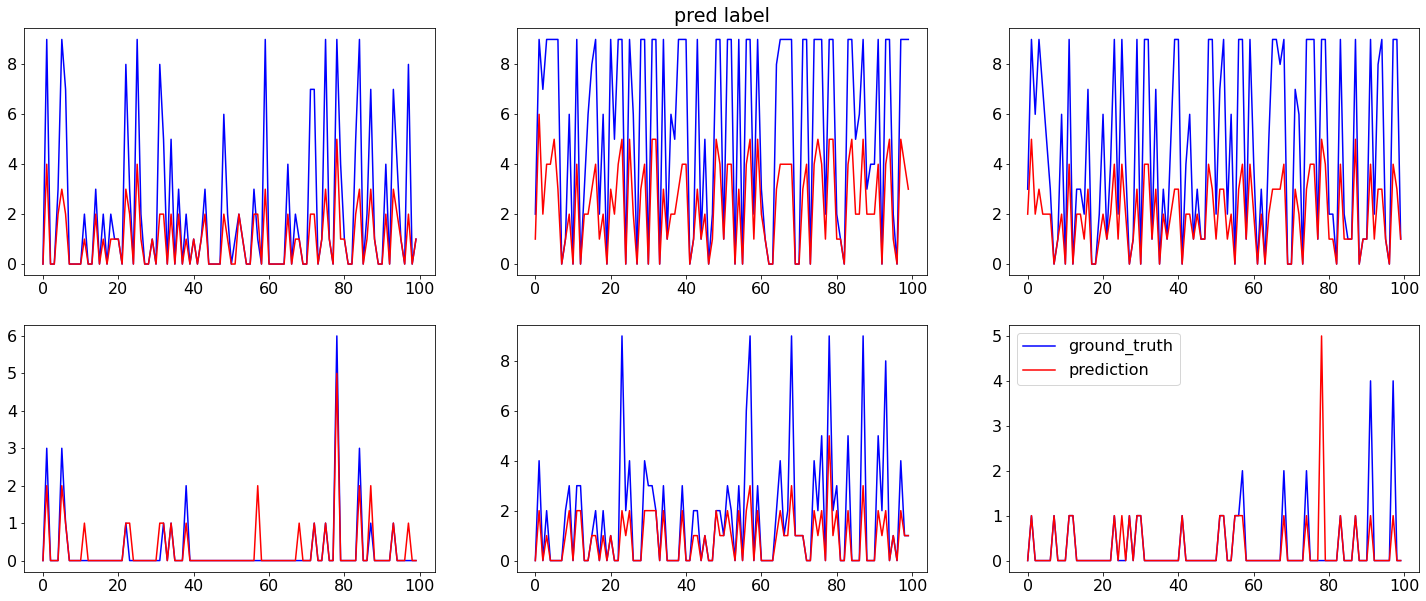

In [11]:
if count_type == "multitask":
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
    axes = axes.flatten()
    for i in range(len(queries)):
        ax = axes[i]
        ax.plot(truth_labels_np[i][0:100], color='blue', label='ground_truth')
        ax.plot(pred_labels_np[i][0:100], color='red', label='prediction')

    ax.legend()
    axes[1].set_title("pred label")

print("avg_error",np.mean(np.abs(truth_labels_np - pred_labels_np)))

## Visualization

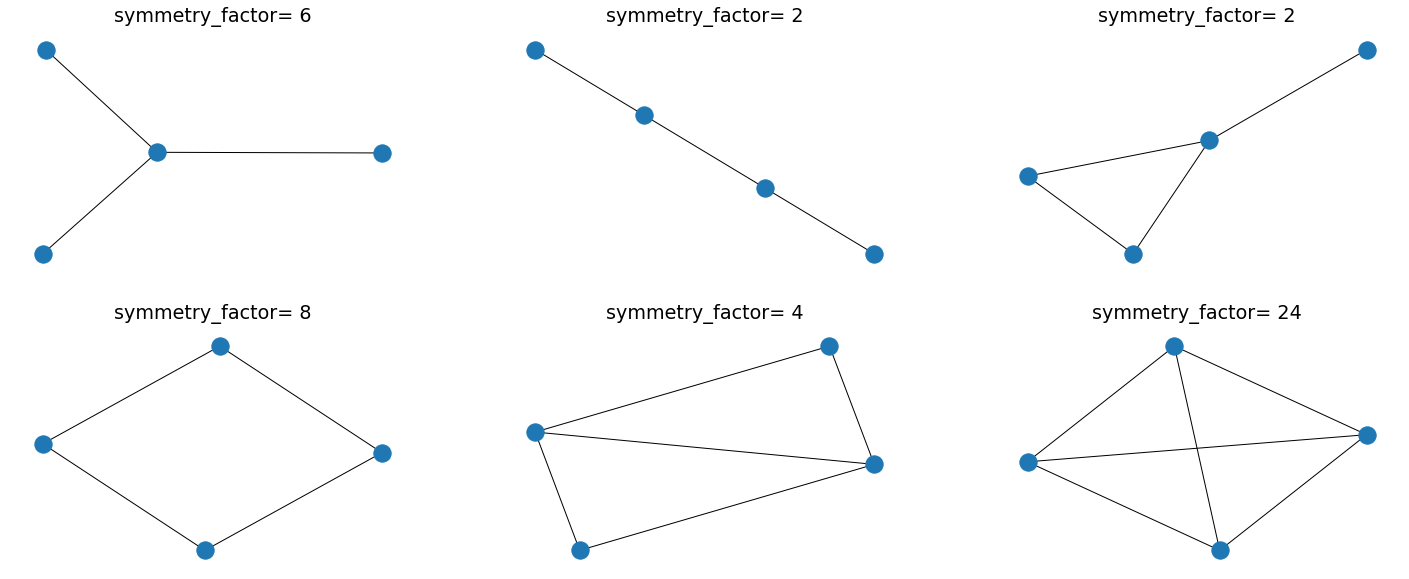

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
axes = axes.flatten()
for i in range(len(queries)):
    nx.draw(queries[i], ax=axes[i])
    axes[i].set_title("symmetry_factor= "+ str(SymmetricFactor(queries[i])))

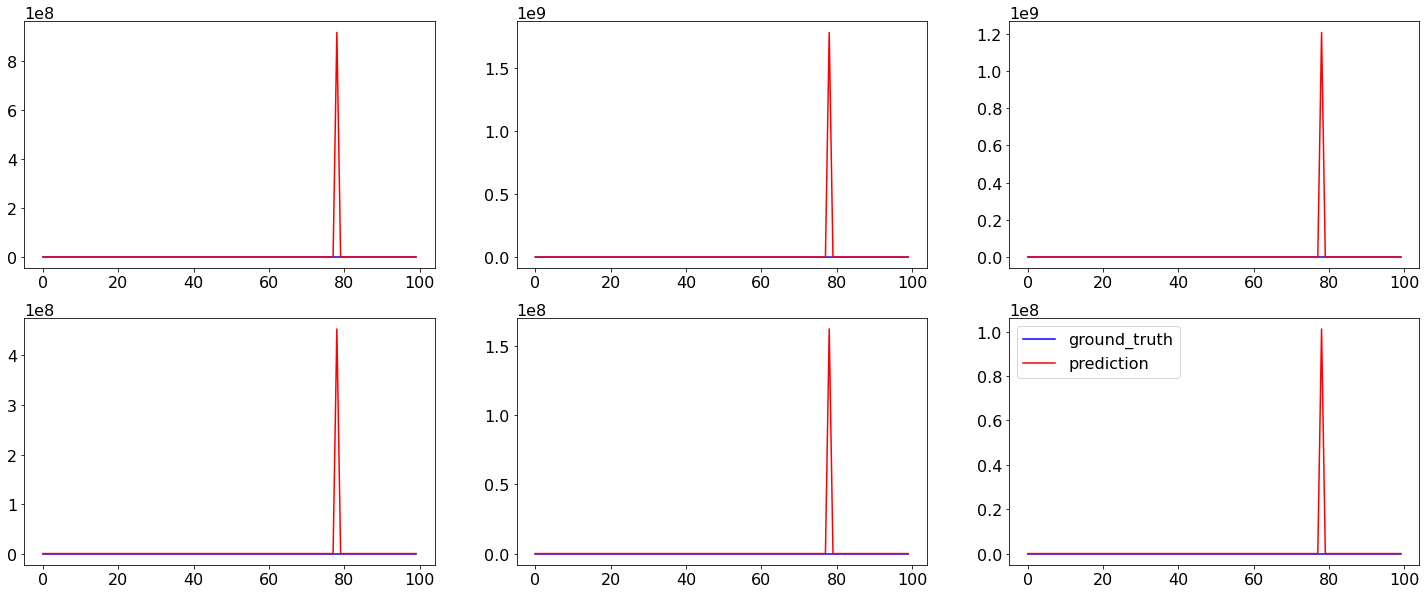

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
axes = axes.flatten()
for i in range(len(queries)):
    ax = axes[i]
    ax.plot(truth_motif_np[i][0:100], color='blue', label='ground_truth')
    ax.plot(preds_np[i][0:100], color='red', label='prediction')

ax.legend()

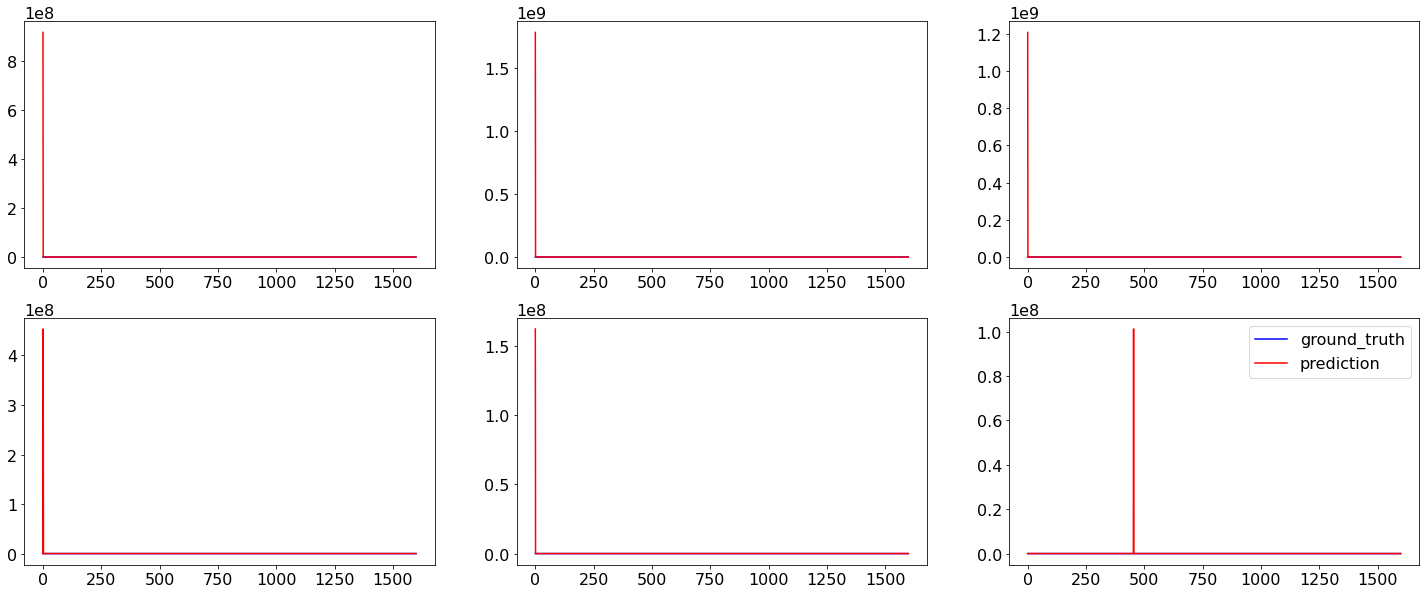

In [ ]:
truths_preds = []
for i in range(len(queries)):
    truth_pred = [(t,p) for t,p in zip(truth_motif_np[i,:], preds_np[i,:])]
    truth_pred.sort(key = lambda x: x[0], reverse= True)
    truths_preds.append(truth_pred)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
axes = axes.flatten()
for i in range(len(queries)):
    ax = axes[i]
    ax.plot([tp[0] for tp in truths_preds[i]], color='blue', label='ground_truth')
    ax.plot([tp[1] for tp in truths_preds[i]], color='red', label='prediction')

ax.legend()

# Get the number of truth count

In [ ]:
neighs_all = []
for graph in tqdm(dataset[0:100]):
    graph = pyg.utils.to_networkx(graph, to_undirected=True)
    for node in graph.nodes:
        neigh = get_neigh_canonical(graph, node, len_neighbor)
        if len(neigh.edges) != 0:
            neighs_all.append(neigh)

truth_motif_all = []
for query in queries:
    truth_all = []
    symmetry_factor = SymmetricFactor(query)
    for target in tqdm(neighs_all):
        # arg_tuple = tuple((query, target) for target in neighs_all)
        # truth = pool.starmap(count_canonical, arg_tuple)
        truth = count_canonical(query, target, symmetry_factor= symmetry_factor)
        # truth_all.extend(truth) 
        truth_all.append(truth)
    truth_all = torch.tensor(truth_all, dtype=torch.float)
    truth_all = torch.unsqueeze(truth_all, -1).to(device)
    truth_motif_all.append(truth_all)

neighs_all = utils.batch_nx_graphs(neighs_all)

 39%|███▉      | 15404/39469 [00:48<01:15, 318.41it/s]


KeyboardInterrupt: 

In [ ]:
neighs_all

Batch(G=[39469], batch=[540539], edge_index=[2, 2062512], edge_label_index=[2, 2062512], node_feature=[540539, 1], node_label_index=[540539])

In [ ]:
neighs_all = neighs_all.to(device)
preds = []
losses = []

with torch.no_grad():
    neighs_valid = neighs_all
    emb_target = model.emb_model(neighs_valid)
    for query_id in tqdm(range(len(queries))):
        truth_valid = truth_motif_all[query_id]
        query = utils.batch_nx_graphs([queries[query_id] for _ in range(len(neighs_valid.G))])
        if args.count_type == "motif":
            emb_query = model.emb_model_query(query)
            emb = torch.cat((emb_target, emb_query), dim=-1)
            results = model.count_model(emb)
            results = torch.round((F.relu(results)))
        elif args.count_type == "multitask":
            emb_query = model.emb_model_query(query)
            emb = torch.cat((emb_target, emb_query), dim=-1)
            count = model.count_model(emb)
            pred_label = model.classification(emb)
            results = (count, pred_label)
        elif args.count_type == "canonical":
            results = model.count_model(emb_target)
            results = torch.round((F.relu(results)))
        if count_type != "canonical":
            pred = results
        else:
            pred = results[0]

        pred = torch.round((F.relu(pred)))
        preds.append(pred.cpu().numpy())


  0%|          | 0/6 [00:13<?, ?it/s]


NameError: name 'args' is not defined

In [ ]:
pred_np = np.concatenate(preds, axis=-1).T
truth_motif_np = torch.cat(truth_motif_all, dim=-1).cpu().numpy().T

print("pred_sum", np.sum(pred_np, axis=-1))
print("truth_sum", np.sum(truth_motif_np, axis=-1)) 
print("sum diff", np.sum(np.abs(pred_np-truth_motif_np), axis=-1))

pred_sum [116847. 657822. 295642.  24977.  83776.   9330.]
truth_sum [104262. 700826. 342166.   8733.  86680.  19389.]
sum diff [44061. 74830. 58122. 19442. 24094. 15079.]
